In [1]:
import numpy as np
import pandas as pd 

### Data preparation

In [2]:
fundamentals_df = pd.read_csv('../input/clear_fundamentals.csv', index_col=0)
fundamentals_df.shape

(428, 12)

In [3]:
sector_embeddings = np.load('../input/sector_embedding.npy')
sector_embeddings.shape

(428, 7)

In [4]:
new_df = pd.concat([
    fundamentals_df, 
    pd.DataFrame(sector_embeddings, index=fundamentals_df.index, columns=['embedding_' + str(i) for i in range(sector_embeddings.shape[-1])])
], axis=1)
new_df.head()

,Symbol,forwardPE,priceToBook,enterpriseToRevenue,profitMargins,trailingEps,forwardEps,beta,52WeekChange,averageVolume,marketCap,payoutRatio,embedding_0,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,embedding_6
0,MMM,19.240505,18.872610,3.682,0.16011,7.20,7.90,1.104,0.156773,3375564.0,8.095977e+10,0.3972,-14.320090,-21.504538,-1.577519,-11.452251,-9.880412,0.347214,2.985690
1,AOS,17.393120,5.373871,5.275,0.13683,3.59,4.07,1.220,-0.090804,1403941.0,9.919802e+09,0.3733,-14.320090,-21.504538,-1.577519,-11.452251,-9.880412,0.347214,2.985690
2,ABT,25.616278,4.549616,5.486,0.32427,7.97,5.16,0.705,0.168700,6356111.0,2.300540e+11,0.2861,21.712490,0.202544,-21.211306,6.440060,-8.864782,-5.857467,0.027519
4,ACN,18.063255,5.179863,2.305,0.11607,12.58,14.07,1.290,-0.254539,3973364.0,1.582981e+11,0.4558,-12.681352,-8.958301,5.405618,23.820467,5.339387,-4.034334,0.060035
5,ADBE,16.958637,12.998881,6.579,0.30392,15.61,20.55,1.517,-0.386368,3889275.0,1.478337e+11,0.0000,-12.681352,-8.958301,5.405618,23.820467,5.339387,-4.034334,0.060035


In [5]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()

fundamentals_embeddings = new_df.drop(columns=['Symbol']).values
fundamentals_embeddings = sc.fit_transform(fundamentals_embeddings)

In [6]:
from torch.utils.data import Dataset, DataLoader, random_split
import torch

class FundamentalEmbeddingDataset(Dataset):
    def __init__(self, data):
        super().__init__()
        self.data = data
    
    def __getitem__(self, index):
        return self.data[index]
    
    def __len__(self):
        return len(self.data)
    
fundamentals_embeddings_dataset = FundamentalEmbeddingDataset(torch.from_numpy(fundamentals_embeddings))

train_set, test_set = random_split(
    fundamentals_embeddings_dataset, [400, len(fundamentals_embeddings_dataset) - 400]
)

train_loader = DataLoader(train_set, shuffle=True)
test_loader = DataLoader(test_set)

### Latent space exploration using AE

In [36]:
import torch 
import torch.nn as nn 
import torch.nn.functional as F
from tqdm.notebook import tqdm 
import matplotlib.pyplot as plt 

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class AE(nn.Module):
    """   
    Autoencoder (AE) class.
    
    Args:
        input_dim (int): Dimensionality of the input data.
        hidden_dim (int): Dimensionality of the hidden layer.
        latent_dim (int): Dimensionality of the latent space.
    """
    
    def __init__(self, input_dim, hidden_dim, latent_dim):
        
        super().__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim //2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, latent_dim)
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim)
        )
    
    def forward(self, x):
        """   
        Performs a forward pass of the AE.
        
        Args:
            x (torch.Tensor): input data
        """
        latent  = self.encoder(x)
        recon_x = self.decoder(latent)
        return latent, recon_x

In [44]:
input_dim = fundamentals_embeddings.shape[1]
latent_dim = 5
hidden_dim = 64
learning_rate = 1e-3

model = AE(input_dim, hidden_dim, latent_dim)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

Epoch [5/100], Train Loss: 0.4607, Test Loss: 0.3411
Epoch [10/100], Train Loss: 0.3978, Test Loss: 0.3004
Epoch [15/100], Train Loss: 0.3443, Test Loss: 0.2903
Epoch [20/100], Train Loss: 0.3164, Test Loss: 0.2780
Epoch [25/100], Train Loss: 0.2894, Test Loss: 0.2635
Epoch [30/100], Train Loss: 0.2733, Test Loss: 0.2281
Epoch [35/100], Train Loss: 0.2697, Test Loss: 0.2967
Epoch [40/100], Train Loss: 0.2437, Test Loss: 0.2626
Epoch [45/100], Train Loss: 0.2634, Test Loss: 0.2155
Epoch [50/100], Train Loss: 0.2473, Test Loss: 0.2291
Epoch [55/100], Train Loss: 0.2432, Test Loss: 0.2081
Epoch [60/100], Train Loss: 0.2295, Test Loss: 0.2165
Epoch [65/100], Train Loss: 0.2446, Test Loss: 0.1973
Epoch [70/100], Train Loss: 0.2408, Test Loss: 0.2367
Epoch [75/100], Train Loss: 0.2256, Test Loss: 0.1966
Epoch [80/100], Train Loss: 0.2122, Test Loss: 0.2211
Epoch [85/100], Train Loss: 0.2077, Test Loss: 0.1882
Epoch [90/100], Train Loss: 0.2195, Test Loss: 0.2333
Epoch [95/100], Train Loss: 0

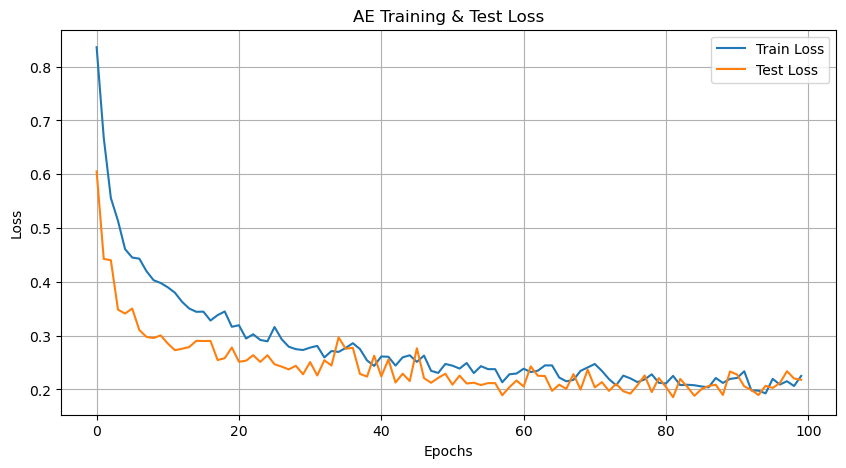

In [45]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

epochs = 100

train_losses = []
test_losses = []

for epoch in range(epochs):
    model.train()
    total_train_loss = 0
    
    for batch in train_loader:
        batch = batch.float().to(device)
        
        _, recon_batch = model(batch)
        
        loss = loss_function(recon_batch, batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_train_loss += np.sqrt(loss.item())
    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    model.eval()
    total_test_loss = 0
    
    with torch.no_grad():
        for batch in test_loader:
            batch = batch.float().to(device)
            _, recon_batch = model(batch)
            loss = loss_function(recon_batch, batch)
            total_test_loss += np.sqrt(loss.item())
    avg_test_loss = total_test_loss / len(test_loader)
    test_losses.append(avg_test_loss)
    
    if (epoch + 1) % 5 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}")
        
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('AE Training & Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

### Retrain the AE using fine-tuned architecture

Epoch [5/100], Final Train Loss: 0.4374
Epoch [10/100], Final Train Loss: 0.3747
Epoch [15/100], Final Train Loss: 0.3295
Epoch [20/100], Final Train Loss: 0.3131
Epoch [25/100], Final Train Loss: 0.3089
Epoch [30/100], Final Train Loss: 0.2838
Epoch [35/100], Final Train Loss: 0.2728
Epoch [40/100], Final Train Loss: 0.2751
Epoch [45/100], Final Train Loss: 0.2577
Epoch [50/100], Final Train Loss: 0.2434
Epoch [55/100], Final Train Loss: 0.2375
Epoch [60/100], Final Train Loss: 0.2361
Epoch [65/100], Final Train Loss: 0.2415
Epoch [70/100], Final Train Loss: 0.2327
Epoch [75/100], Final Train Loss: 0.2295
Epoch [80/100], Final Train Loss: 0.2164
Epoch [85/100], Final Train Loss: 0.2172
Epoch [90/100], Final Train Loss: 0.2190
Epoch [95/100], Final Train Loss: 0.2215
Epoch [100/100], Final Train Loss: 0.2051


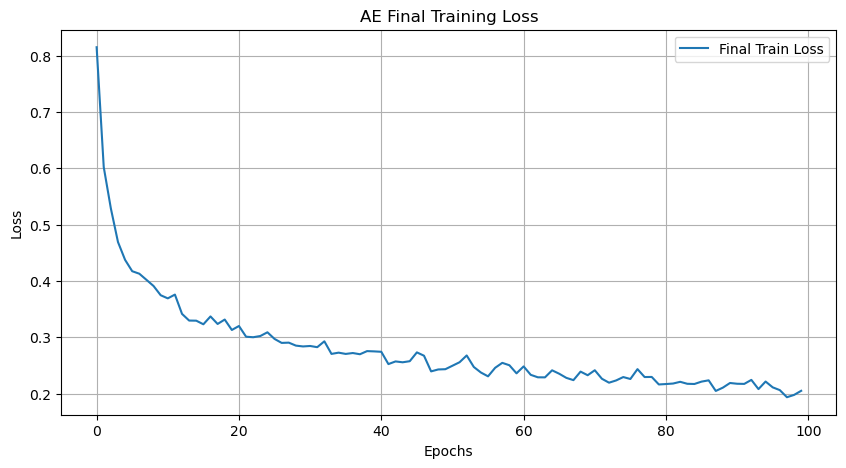

In [48]:
model = AE(input_dim=input_dim, hidden_dim=hidden_dim, latent_dim=latent_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


full_dataset = FundamentalEmbeddingDataset(fundamentals_embeddings_dataset)
full_loader = DataLoader(full_dataset)

final_train_losses = []
epochs = 100
for epoch in range(epochs):
    
    model.train()
    total_epoch_loss = 0
    
    for batch in full_loader:
        batch = batch.float().to(device)
        _, recon = model(batch)
        loss = loss_function(recon, batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_epoch_loss += np.sqrt(loss.item())
        
    avg_epoch_loss = total_epoch_loss / len(full_loader)
    final_train_losses.append(avg_epoch_loss)
    
    if (epoch + 1) % 5 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Final Train Loss: {avg_epoch_loss:.4f}")

plt.figure(figsize=(10, 5))
plt.plot(final_train_losses, label='Final Train Loss')
plt.title('AE Final Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [49]:
model.eval()
with torch.no_grad():
    latent_embeddings, _ = model(torch.from_numpy(fundamentals_embeddings).float())
    latent_embeddings = latent_embeddings.numpy()
latent_embeddings.shape

(428, 5)

### Adjacency matrix construction 

In [51]:
from sklearn.metrics import pairwise_distances

In [61]:
distance_matrix = pairwise_distances(latent_embeddings, metric='cosine')
distance_matrix[:5, :5], distance_matrix.shape

(array([[0.        , 0.03947127, 1.5763321 , 1.5170515 , 1.4656388 ],
        [0.03947127, 0.        , 1.5714335 , 1.3778708 , 1.3457583 ],
        [1.5763321 , 1.5714335 , 0.        , 1.2170545 , 1.2234967 ],
        [1.5170515 , 1.3778708 , 1.2170545 , 0.        , 0.05903447],
        [1.4656388 , 1.3457583 , 1.2234967 , 0.05903447, 0.        ]],
       dtype=float32),
 (428, 428))

In [62]:
epsilon = 0.5
gamma_squared = 0.1

adj_matrix = np.exp(- (distance_matrix ** 2 / gamma_squared)) - np.identity(distance_matrix.shape[0])

adj_matrix[adj_matrix < epsilon] = 0

### Graph representation

In [56]:
import networkx as nx

In [57]:
domain_df = pd.read_csv('../input/clear_domain.csv', index_col=0)

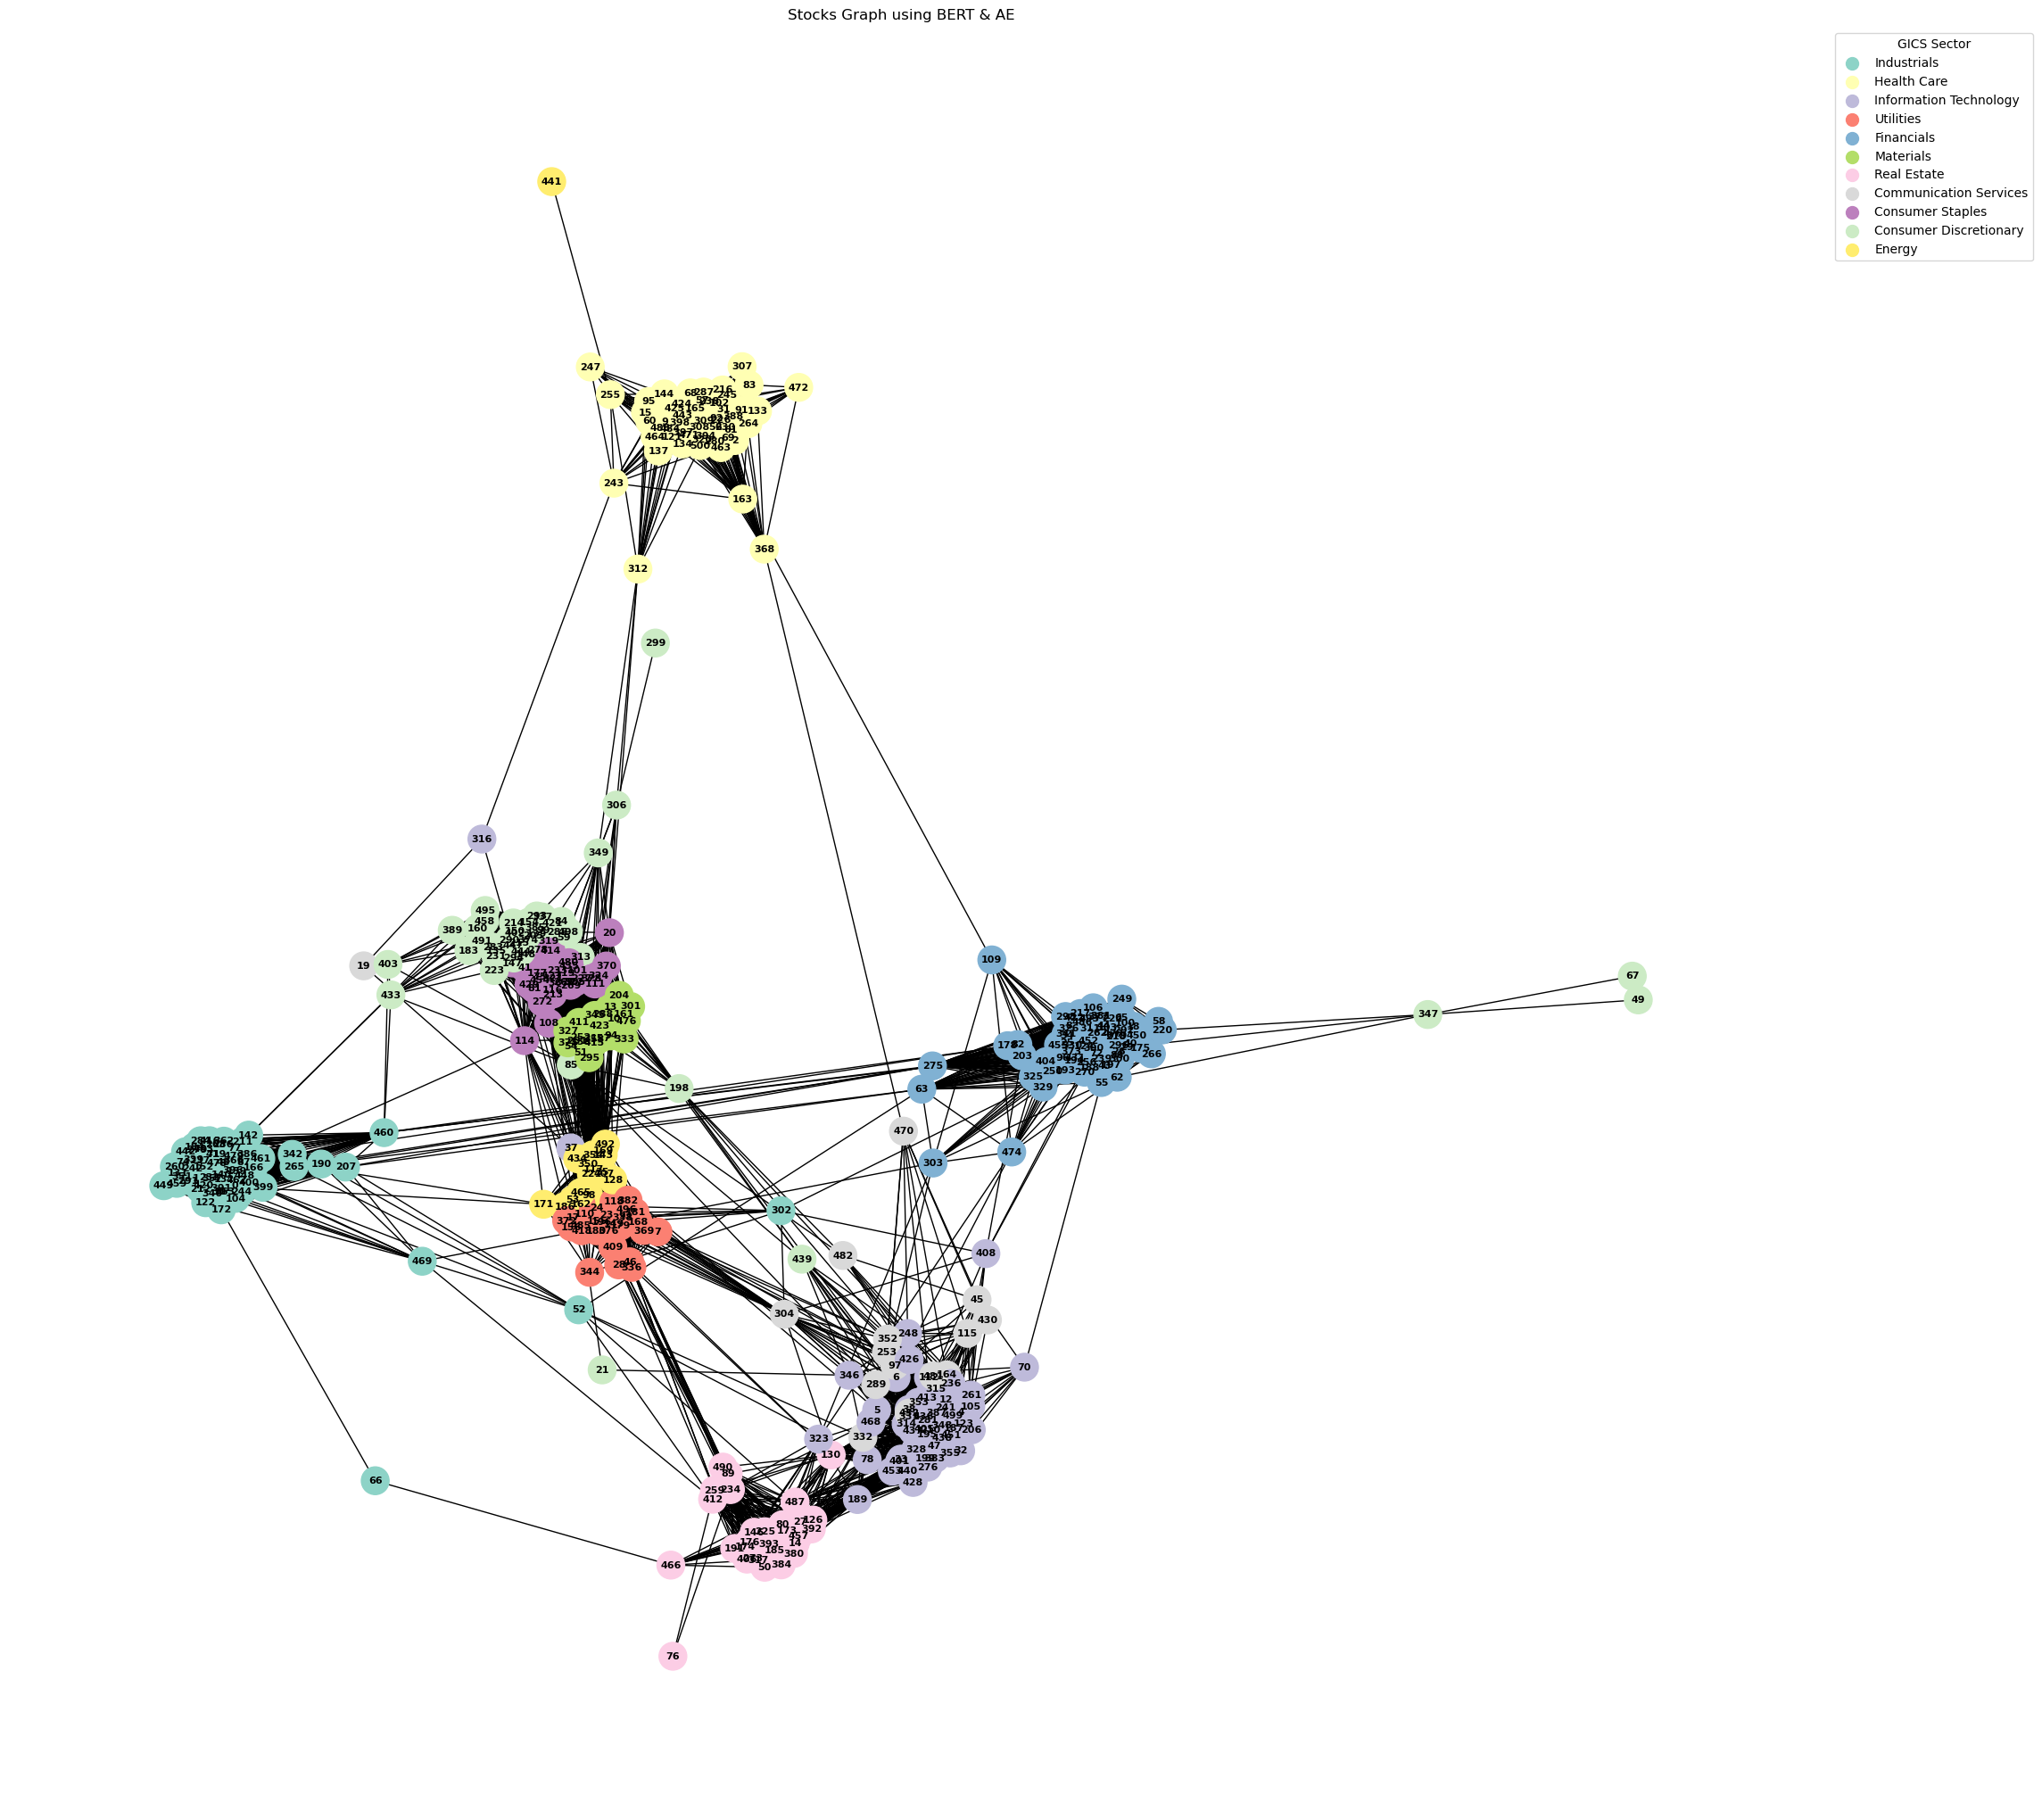

In [75]:
final_graph = nx.from_numpy_array(adj_matrix)
final_graph = nx.relabel_nodes(final_graph, dict(enumerate(fundamentals_df.index)))

# Tạo màu sắc cho từng sector
sectors = domain_df['GICS Sector'].unique()
colors = plt.cm.Set3(np.linspace(0, 1, len(sectors)))
sector_color_map = dict(zip(sectors, colors))

# Gán màu cho từng node
node_colors = [sector_color_map[domain_df.loc[node, 'GICS Sector']] 
               for node in final_graph.nodes()]

plt.figure(figsize=(20, 20))
nx.draw(final_graph, with_labels=True, node_size=500, node_color=node_colors, font_size=8, font_weight='bold', font_color='black', pos=nx.spring_layout(final_graph))

for sector, color in sector_color_map.items():
    plt.scatter([], [], c=[color], label=sector, s=100)

# Định vị và hiển thị chú thích
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', title='GICS Sector')

plt.title('Stocks Graph using BERT & AE')
plt.show()


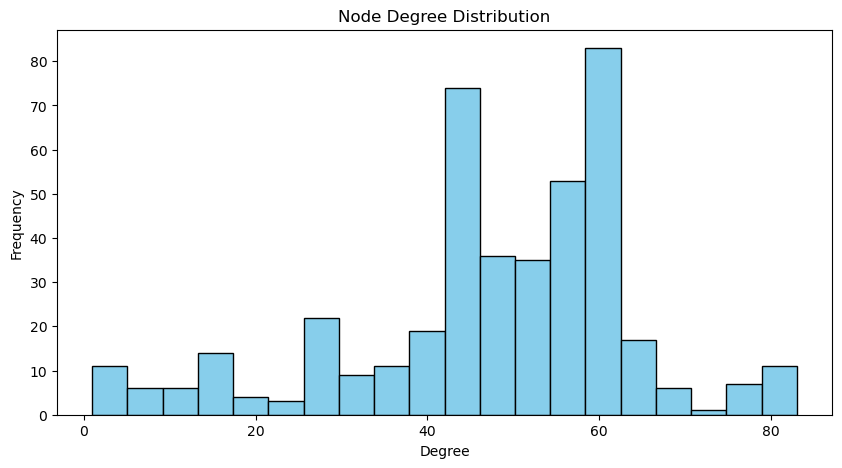

In [76]:
plt.figure(figsize=(10, 5))

connection_num = np.sum((np.abs(adj_matrix) > 0).astype(int), 1)

plt.hist(connection_num, bins=20, color='skyblue', edgecolor='black')
plt.title('Node Degree Distribution')
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.show()

In [77]:
np.save('../input/adj_ae-bert.npy', adj_matrix)